<a href="https://colab.research.google.com/github/bibake/FashionMNST_ImageClassification/blob/master/BasicImageClassification_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ML III**

04-2020

Bibake Uppal

###### Licences

<font size="1"> Copyright 2018 The TensorFlow Authors.

<font size="1"><font size="1">Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License.
You may obtain a copy of the License [here](https://www.apache.org/licenses/LICENSE-2.0). Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<font size="1">MIT License

<font size="1">Copyright (c) 2017 François Chollet

<font size="1">Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following conditions:

<font size="1">The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE. </font>

---



# Basic classification: Classify images of clothing

This notebook trains a neural network model to classify images of clothing, like sneakers and shirts.

This notebook uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and Keras for modelling
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.callbacks import EarlyStopping

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import cv2
from sklearn.metrics import classification_report

print(tf.__version__)

%load_ext tensorboard
!rm -rf ./logs/

np.random.seed(123)

2.2.0-rc2
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## 1. Preperation

### 1.1 – Import the Fashion MNIST dataset

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

In [0]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 1.2 – Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [0]:
train_images.shape

(60000, 28, 28)

Likewise, there are 60,000 labels in the training set:

In [0]:
len(train_labels)

60000

Each label is an integer between 0 and 9:

In [0]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [0]:
test_images.shape

(10000, 28, 28)

And the test set contains 10,000 images labels:

In [0]:
len(test_labels)

10000

### 1.3 – Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

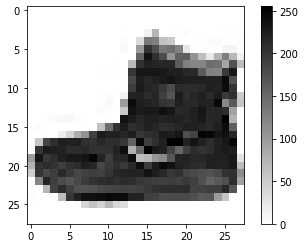

In [0]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [0]:
train_images = train_images / 255.0

test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

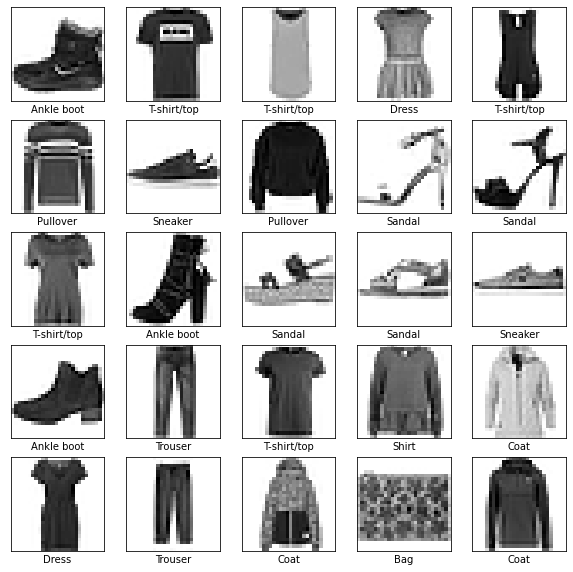

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 2. Modelling

Building the neural network requires configuring the layers of the model, then compiling the model.

### 2.1 – Base Perceptron

#### 2.1.1 – Set up the layers

The basic building block of a neural network is the *layer*. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.3),
    # keras.layers.Dense(150, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    # keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 512 nodes (or neurons). The second (and last) layer is a 10-node *softmax* layer that returns an array of 10 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

#### 2.1.2 – Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* *Loss function* —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* *Optimizer* —This is how the model is updated based on the data it sees and its loss function.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [0]:
model.compile(optimizer='Adamax',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               51300     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1010      
Total params: 454,230
Trainable params: 454,230
Non-trainable params: 0
_________________________________________________________________


#### 2.1.3 – Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array. Verify that the predictions match the labels from the `test_labels` array.

To start training,  call the `model.fit` method—so called because it "fits" the model to the training data:

In [0]:
es = EarlyStopping(patience = 5, restore_best_weights=True)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [0]:
np.random.seed(123)
history = model.fit(train_images, train_labels, epochs=1000, callbacks=[es, tensorboard_callback], validation_split=0.3)

Epoch 1/1000
1313/1313 [==============================] - 29s 22ms/step - loss: 0.5732 - accuracy: 0.7990 - val_loss: 0.4486 - val_accuracy: 0.8349
Epoch 2/1000
1313/1313 [==============================] - 30s 23ms/step - loss: 0.4266 - accuracy: 0.8462 - val_loss: 0.3887 - val_accuracy: 0.8604
Epoch 3/1000
1313/1313 [==============================] - 29s 22ms/step - loss: 0.3818 - accuracy: 0.8616 - val_loss: 0.3546 - val_accuracy: 0.8733
Epoch 4/1000
1313/1313 [==============================] - 29s 22ms/step - loss: 0.3540 - accuracy: 0.8695 - val_loss: 0.3475 - val_accuracy: 0.8748
Epoch 5/1000
1313/1313 [==============================] - 29s 22ms/step - loss: 0.3360 - accuracy: 0.8778 - val_loss: 0.3581 - val_accuracy: 0.8708
Epoch 6/1000
1313/1313 [==============================] - 29s 22ms/step - loss: 0.3221 - accuracy: 0.8813 - val_loss: 0.3305 - val_accuracy: 0.8807
Epoch 7/1000
1313/1313 [==============================] - 29s 22ms/step - loss: 0.3092 - accuracy: 0.8868 - val_

#### 2.1.4 – Results

In [0]:
print('The average accuracy for the last 3 epochs is: %.4f.' % np.mean(history.history['val_accuracy'][-3:]))

The average accuracy for the last 3 epochs is: 0.8966.


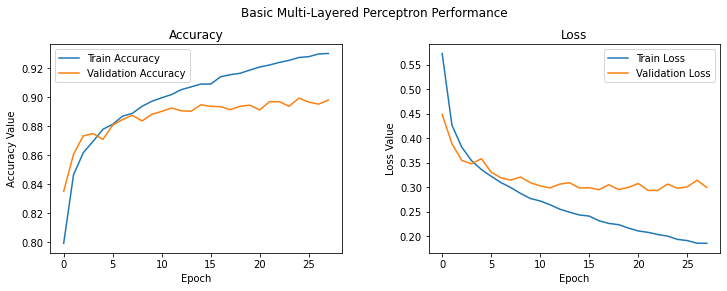

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic Multi-Layered Perceptron Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(len(history.history['loss'])))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
results_df = pd.DataFrame(columns=['Approach', 'Accuracy'])
results_df.loc[len(results_df)] = ['Base Perceptron', np.mean(history.history['val_accuracy'][-4])]
results_df

,Approach,Accuracy
0,Base Perceptron,0.899333


### 2.2 – Convolutional Neural Networks

#### 2.2.1 – Preprocess the data

In [0]:
train_imgs = [img_to_array(i) for i in train_images]
train_imgs = np.array(train_imgs)

test_imgs =  [img_to_array(i) for i in test_images]
test_imgs = np.array(test_imgs)

print(train_imgs.shape)
print(test_imgs.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [0]:
print(train_imgs[0].shape)
array_to_img(train_imgs[0])

(28, 28, 1)


#### 2.2.2 – Base CNN

##### 2.2.2.1 – Set up and compile model

In [0]:
# batch_size = 6000
num_classes = 10
epochs = 1000
input_shape = (28, 28, 1)
es = EarlyStopping(patience=3, restore_best_weights=True)

In [0]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32, kernel_size=(3, 3), use_bias=False, 
                 input_shape=(input_shape)))
model_cnn.add(tf.keras.layers.BatchNormalization(axis=-1))
model_cnn.add(tf.keras.layers.Activation("relu"))

model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dense(10, activation='softmax'))


model_cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        288       
_________________________________________________________________
batch_normalization_5 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)         

##### 2.2.2.2 – Train the model

In [0]:
tf.config.experimental_run_functions_eagerly(True)

In [0]:
np.random.seed(123)
history = model_cnn.fit(x=train_imgs, y=train_labels,
                        # batch_size=batch_size,
                        epochs=epochs,
                        callbacks = [es, tensorboard_callback],
                        validation_split=0.3)

Epoch 1/1000
1313/1313 [==============================] - 61s 46ms/step - loss: 0.4353 - accuracy: 0.8439 - val_loss: 0.3795 - val_accuracy: 0.8635
Epoch 2/1000
1313/1313 [==============================] - 59s 45ms/step - loss: 0.3029 - accuracy: 0.8936 - val_loss: 0.3012 - val_accuracy: 0.8932
Epoch 3/1000
1313/1313 [==============================] - 59s 45ms/step - loss: 0.2832 - accuracy: 0.8995 - val_loss: 0.3863 - val_accuracy: 0.8676
Epoch 4/1000
1313/1313 [==============================] - 59s 45ms/step - loss: 0.2736 - accuracy: 0.9035 - val_loss: 0.5248 - val_accuracy: 0.8792
Epoch 5/1000
1313/1313 [==============================] - 59s 45ms/step - loss: 0.2812 - accuracy: 0.9051 - val_loss: 0.3522 - val_accuracy: 0.8821


##### 2.2.2.3 – Results

In [0]:
print('The average accuracy for the last 3 epochs is: %.4f.' % np.mean(history.history['val_accuracy'][-3:]))

The average accuracy for the last 3 epochs is: 0.8763.


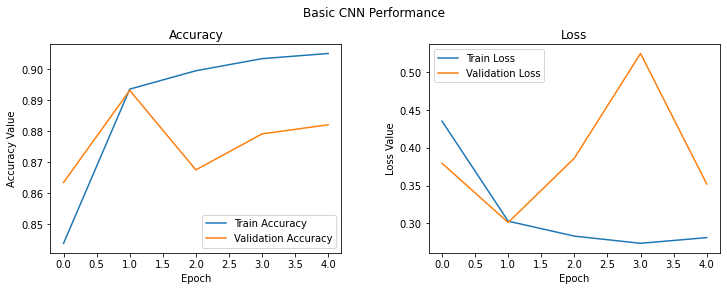

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(len(history.history['loss'])))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
results_df.loc[len(results_df)] = ['Base CNN', np.mean(history.history['val_accuracy'][-4])]
results_df

,Approach,Accuracy
0,Base Perceptron,0.899333
1,Base CNN,0.893222


#### 2.2.3 – CNN with Regularization

##### 2.2.3.1 – Set up and compile model

In [0]:
batch_size = 6000
num_classes = 10
epochs = 1000
input_shape = (28, 28, 1)
es = EarlyStopping(patience=3, restore_best_weights=True)

In [0]:
model_cnn2 = Sequential()

model_cnn2.add(Conv2D(32, kernel_size=(3, 3), use_bias=False,
                 input_shape=(input_shape)))
model_cnn2.add(tf.keras.layers.BatchNormalization(axis=-1))
model_cnn2.add(tf.keras.layers.Activation("relu"))

model_cnn2.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn2.add(Flatten())

model_cnn2.add(Dense(512, activation='relu'))
model_cnn2.add(Dropout(0.4))

model_cnn2.add(Dense(100, activation='relu'))
model_cnn2.add(Dropout(0.2))

model_cnn2.add(Dense(100, activation='relu'))
model_cnn2.add(Dropout(0.2))

model_cnn2.add(Dense(10, activation='softmax'))


model_cnn2.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

model_cnn2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 32)        288       
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)         

##### 2.2.3.2 – Train the model

In [0]:
np.random.seed(123)
history = model_cnn2.fit(x=train_imgs, y=train_labels,
                         epochs=epochs,
                         callbacks = [es, tensorboard_callback],
                        #  batch_size=batch_size,
                         validation_split=0.3,
                         verbose = 1)

Epoch 1/1000
1313/1313 [==============================] - 50s 38ms/step - loss: 0.5585 - accuracy: 0.7996 - val_loss: 0.3432 - val_accuracy: 0.8728
Epoch 2/1000
1313/1313 [==============================] - 49s 37ms/step - loss: 0.3458 - accuracy: 0.8760 - val_loss: 0.3314 - val_accuracy: 0.8753
Epoch 3/1000
1313/1313 [==============================] - 49s 37ms/step - loss: 0.2869 - accuracy: 0.8986 - val_loss: 0.2867 - val_accuracy: 0.8876
Epoch 4/1000
1313/1313 [==============================] - 50s 38ms/step - loss: 0.2597 - accuracy: 0.9073 - val_loss: 0.2861 - val_accuracy: 0.8914
Epoch 5/1000
1313/1313 [==============================] - 51s 39ms/step - loss: 0.2385 - accuracy: 0.9156 - val_loss: 0.2582 - val_accuracy: 0.9026
Epoch 6/1000
1313/1313 [==============================] - 51s 39ms/step - loss: 0.2125 - accuracy: 0.9247 - val_loss: 0.2593 - val_accuracy: 0.9077
Epoch 7/1000
1313/1313 [==============================] - 51s 39ms/step - loss: 0.1906 - accuracy: 0.9319 - val_

##### 2.2.3.3 – Results

In [0]:
print('The average accuracy for the last 3 epochs is: %.4f.' % np.mean(history.history['val_accuracy'][-3:]))

The average accuracy for the last 3 epochs is: 0.9147.


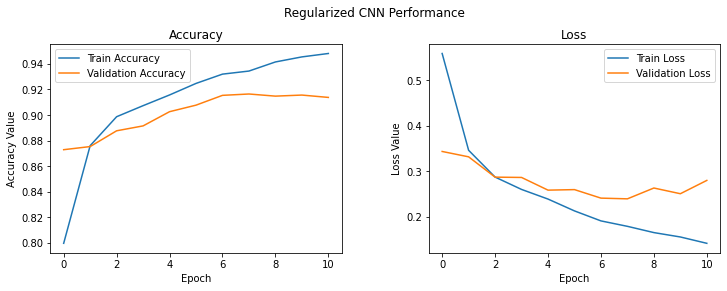

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Regularized CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(len(history.history['loss'])))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
results_df.loc[len(results_df)] = ['Regularized CNN', np.mean(history.history['val_accuracy'][-4])]
results_df

,Approach,Accuracy
0,Base Perceptron,0.899333
1,Base CNN,0.893222
2,Regularized CNN,0.916389


#### 2.2.4 – Pre-trained CNN model as Feature Exractor

##### 2.2.4.1 – Prepare data

In order to feed our data into the pre-trained model, it must be replicated across the three color channels: RGB. This is done here:

In [0]:
train_imgs_rgb = [np.dstack([a, a, a]) for a in train_images]
train_imgs_rgb = [np.pad(a, ((2, 2), (2, 2), (0, 0)), mode='constant', constant_values=0) for a in train_imgs_rgb]
train_imgs_rgb = np.array(train_imgs_rgb)

test_imgs_rgb = [np.dstack([a, a, a]) for a in test_images]
test_imgs_rgb = [np.pad(a, ((2, 2), (2, 2), (0, 0)), mode='constant', constant_values=0) for a in test_imgs_rgb]
test_imgs_rgb = np.array(test_imgs_rgb)

##### 2.2.4.2 – Load and prepare pre-trained model

In [0]:
input_shape = (32,32,3)

vgg = vgg16.VGG16(include_top=False, weights='imagenet',
                  input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

58892288/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f976eb676a0>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f976eb67400>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9747f947f0>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9747fb41d0>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f974879cc18>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f97487a75f8>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f97487ad668>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f97487badd8>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f97482ee940>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f97482fdb00>,block3_conv3,False


##### 2.2.4.3 – Get relevant features

In [0]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_rgb)
validation_features_vgg = get_bottleneck_features(vgg_model, test_imgs_rgb)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (60000, 512) 	Validation Bottleneck Features: (10000, 512)


##### 2.2.4.4 – Set up and compile model

In [0]:
es = EarlyStopping(patience = 3, restore_best_weights=True)

input_shape = vgg_model.output_shape[1]

model_cnn3 = Sequential()

model_cnn3.add(InputLayer(input_shape=(input_shape,)))

model_cnn3.add(Dense(512, activation='relu', input_dim=input_shape))
model_cnn3.add(Dropout(0.3))

model_cnn3.add(Dense(100, activation='relu'))
model_cnn3.add(Dropout(0.2))

model_cnn3.add(Dense(100, activation='relu'))
model_cnn3.add(Dropout(0.2))

model_cnn3.add(Dense(100, activation='relu'))
model_cnn3.add(Dropout(0.2))

model_cnn3.add(Dense(10, activation='softmax'))


model_cnn3.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(lr = 1e-4),
              metrics=['accuracy'])

model_cnn3.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               51300     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)              

Note: the learning rate has been reduced to avoid falling into local minima.

##### 2.2.4.5 – Train the model

In [0]:
np.random.seed(123)
history = model_cnn3.fit(x=train_features_vgg, y=train_labels,
                     validation_split = 0.3,
                    #  batch_size=6000,
                     epochs=1000,
                     callbacks = [es, tensorboard_callback],                                                                            
                     verbose=1)

Epoch 1/1000
1313/1313 [==============================] - 38s 29ms/step - loss: 1.2004 - accuracy: 0.5639 - val_loss: 0.6263 - val_accuracy: 0.7702
Epoch 2/1000
1313/1313 [==============================] - 37s 28ms/step - loss: 0.6851 - accuracy: 0.7543 - val_loss: 0.5204 - val_accuracy: 0.8067
Epoch 3/1000
1313/1313 [==============================] - 37s 28ms/step - loss: 0.5839 - accuracy: 0.7933 - val_loss: 0.4765 - val_accuracy: 0.8226
Epoch 4/1000
1313/1313 [==============================] - 37s 28ms/step - loss: 0.5275 - accuracy: 0.8125 - val_loss: 0.4470 - val_accuracy: 0.8341
Epoch 5/1000
1313/1313 [==============================] - 37s 28ms/step - loss: 0.4939 - accuracy: 0.8234 - val_loss: 0.4240 - val_accuracy: 0.8421
Epoch 6/1000
1313/1313 [==============================] - 37s 28ms/step - loss: 0.4682 - accuracy: 0.8342 - val_loss: 0.4159 - val_accuracy: 0.8480
Epoch 7/1000
1313/1313 [==============================] - 37s 28ms/step - loss: 0.4429 - accuracy: 0.8413 - val_

##### 2.2.4.6 – Results

In [0]:
print('The average accuracy for the last 3 epochs is: %.4f.' % np.mean(history.history['val_accuracy'][-3:]))

The average accuracy for the last 3 epochs is: 0.8830.


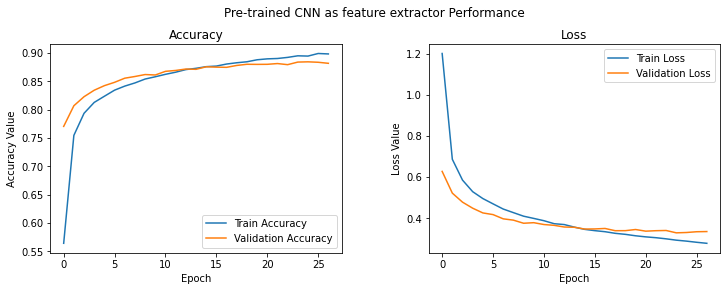

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN as feature extractor Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(len(history.history['loss'])))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
results_df.loc[len(results_df)] = ['Pre-trained CNN (feature extractor)', np.mean(history.history['val_accuracy'][-4])]
results_df

,Approach,Accuracy
0,Base Perceptron,0.899333
1,Base CNN,0.893222
2,Regularized CNN,0.916389
3,Pre-trained CNN (feature extractor),0.883722


#### 2.2.5 – Pre-trained CNN model with Fine-tuning

##### 2.2.5.1 – Prepare pre-trained model

In [0]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f976eb676a0>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f976eb67400>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9747f947f0>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9747fb41d0>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f974879cc18>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f97487a75f8>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f97487ad668>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f97487badd8>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f97482ee940>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f97482fdb00>,block3_conv3,False


##### 2.2.5.2 – Set up and compile model

In [0]:
model_cnn4 = Sequential()
model_cnn4.add(vgg_model)

model_cnn4.add(Dense(128, activation='relu'))
model_cnn4.add(Dropout(0.2))

model_cnn4.add(Dense(100, activation='relu'))
model_cnn4.add(Dropout(0.2))

model_cnn4.add(Dense(100, activation='relu'))
model_cnn4.add(Dropout(0.2))

model_cnn4.add(Dense(10, activation='softmax'))


model_cnn4.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model_cnn4.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_28 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)             

##### 2.2.5.2 – Train the model

In [0]:
np.random.seed(123)
history = model_cnn4.fit(x=train_imgs_rgb, y=train_labels,
                         validation_split = 0.3,
                        #  batch_size=6000,
                         epochs=1000,
                         callbacks = [EarlyStopping(patience = 3, restore_best_weights=True), tensorboard_callback],
                         verbose=1)

Epoch 1/1000
1313/1313 [==============================] - 151s 115ms/step - loss: 0.6160 - accuracy: 0.8000 - val_loss: 0.3739 - val_accuracy: 0.8797
Epoch 2/1000
1313/1313 [==============================] - 149s 114ms/step - loss: 0.4170 - accuracy: 0.8711 - val_loss: 0.4285 - val_accuracy: 0.8827
Epoch 3/1000
1313/1313 [==============================] - 148s 113ms/step - loss: 0.4115 - accuracy: 0.8752 - val_loss: 0.4584 - val_accuracy: 0.8570
Epoch 4/1000
1313/1313 [==============================] - 148s 112ms/step - loss: 0.4117 - accuracy: 0.8785 - val_loss: 0.4786 - val_accuracy: 0.8836


##### 2.2.5.3 – Results

In [0]:
print('The average accuracy for the last 3 epochs is: %.4f.' % np.mean(history.history['val_accuracy'][-3:]))

The average accuracy for the last 3 epochs is: 0.8744.


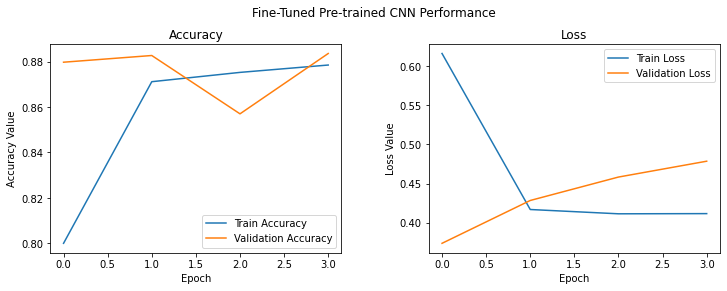

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Fine-Tuned Pre-trained CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(len(history.history['loss'])))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
results_df.loc[len(results_df)] = ['Pre-trained CNN (fine-tuning)', np.mean(history.history['val_accuracy'][-4])]
results_df

,Approach,Accuracy
0,Base Perceptron,0.899333
1,Base CNN,0.893222
2,Regularized CNN,0.916389
3,Pre-trained CNN (feature extractor),0.883722
4,Pre-trained CNN (fine-tuning),0.879722


In [0]:
%tensorboard --logdir logs/fit

## 3. Evaluation

Next, compare how the model performs on the test dataset and make some predictions.

### 3.1 – Performance

In [0]:
# test_loss, test_acc = model_cnn4.evaluate(test_imgs_rgb,  test_labels, verbose=2)

# print('\nTest accuracy:', test_acc)

In [0]:
test_loss, test_acc = model_cnn2.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 5s - loss: 0.2595 - accuracy: 0.9115

Test accuracy: 0.9114999771118164


### 3.2 – Predictions

In [0]:
predictions = model_cnn2.predict(test_images)

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

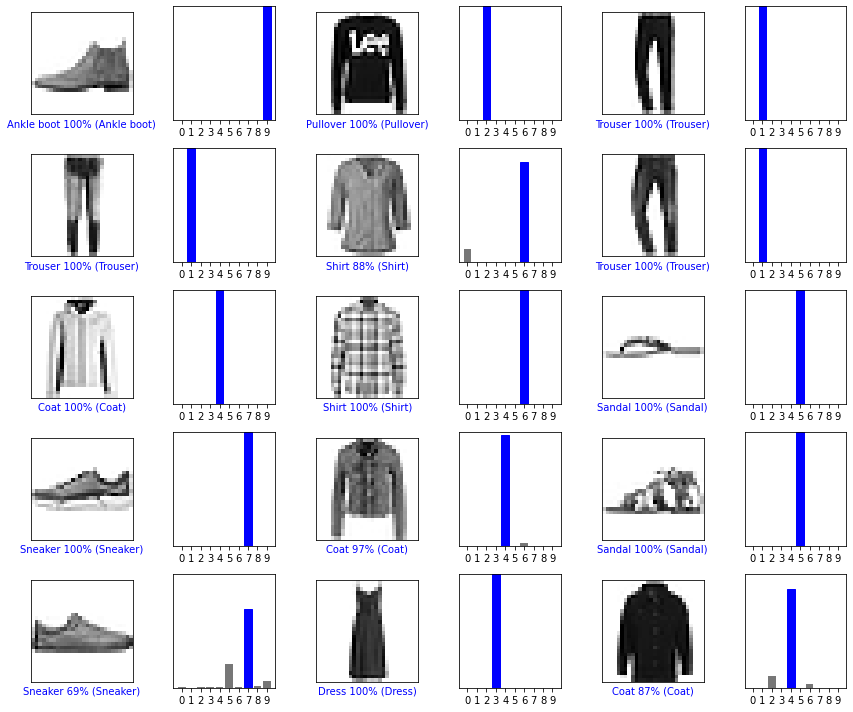

In [0]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [0]:
preds = []

for i in predictions:
  preds.append(np.argmax(i))

In [0]:
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.91      0.84      0.87      1000
           3       0.93      0.89      0.91      1000
           4       0.84      0.90      0.87      1000
           5       0.99      0.97      0.98      1000
           6       0.71      0.78      0.74      1000
           7       0.96      0.97      0.96      1000
           8       0.97      0.98      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

